In [9]:
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from skimage.metrics import structural_similarity as ssim, normalized_root_mse, hausdorff_distance

%matplotlib inline

In [10]:
from src.Tile import Tile

# Filtering by symmetry

In [11]:
folder = 'azulejo'

In [12]:
sample_square = [_.strip() for _ in open('square_{}.txt'.format(folder), 'r').readlines()]

In [40]:
symmetry_measure = [None] * len(sample_square)
symmetry_pieces = [None] * len(sample_square)

cut_off_ssim = 0.97
cut_off_mse = 0.03

sample_symmetric = []
sample_multitile = []
sample_other = []

def check_symmetry(tile, metric='ssim'):
    if metric not in ('ssim', 'normalized_root_mse'):
        print('{} is not currently supported'.format(metric))
        return
    
    tile_compare = [
        [tile, tile.flip_horizontal()],
        [tile, tile.flip_vertical()],
        [tile, tile.flip_transpose()],
        [tile, tile.rotate(clockwise=False).flip_transpose().rotate(clockwise=True)]
    ]

    symmetry_measure_list = []
    for i in range(len(tile_compare)):
        tile0, tile1 = tile_compare[i]
        if metric == 'ssim':
            symmetry_measure = ssim(tile0.img, tile1.img, multichannel=True)
        elif metric == 'normalized_root_mse':
            symmetry_measure = normalized_root_mse(tile0.img, tile1.img)
        symmetry_measure_list.append(symmetry_measure)

    if metric == 'ssim':
        return np.max(symmetry_measure_list)
    if metric == 'normalized_root_mse':
        return np.min(symmetry_measure_list)

for i, img_file in enumerate(sample_square):
    if img_file.endswith(".jpg"):
        img = cv2.imread('dataset/{}/{}'.format(folder, img_file))[...,::-1]
        
        # correcting the shape in case not square
        new_shape = min(img.shape[0], img.shape[1])
        img = img[0:new_shape, 0:new_shape, ...]
        
        img = cv2.resize(img, (64, 64))
        
        symmetry_measure[i] = {}
        
        symmetry_measure[i]['ssim'] = np.max([
            check_symmetry(Tile(img), metric='ssim'),
            check_symmetry(Tile(img).get_rhombus(), metric='ssim')
        ])
        
        symmetry_measure[i]['normalized_root_mse'] = np.min([
            check_symmetry(Tile(img), metric='normalized_root_mse'),
            check_symmetry(Tile(img).get_rhombus(), metric='normalized_root_mse')
        ])
            
        symmetry_pieces[i] = {}        
        symmetry_pieces[i]['ssim'] = []
        symmetry_pieces[i]['normalized_root_mse'] = []
        for n in (4, 9, 16, 25, 36):
            tile_list = Tile(img).get_pieces(n)
            
            symmetry_by_piece = np.min([check_symmetry(tile_piece, metric='ssim') for tile_piece in tile_list])
            symmetry_pieces[i]['ssim'].append(symmetry_by_piece)
            
            symmetry_by_piece = np.max([check_symmetry(tile_piece, metric='normalized_root_mse') for tile_piece in tile_list])
            symmetry_pieces[i]['normalized_root_mse'].append(symmetry_by_piece)
        
        if (symmetry_measure[i]['ssim'] >= cut_off_ssim) or \
            (symmetry_measure[i]['normalized_root_mse'] <= cut_off_mse):
            sample_symmetric.append(img_file)
        if (max(symmetry_pieces[i]['ssim']) >= cut_off_ssim) or \
            (min(symmetry_pieces[i]['normalized_root_mse']) <= cut_off_mse):
            sample_multitile.append(img_file)

In [ ]:
Tile.plot_grid(
    [Tile(cv2.imread('dataset/{}/{}'.format(folder, img_file))[...,::-1]) for img_file in sample_symmetric[:36]],
    cols=6
)

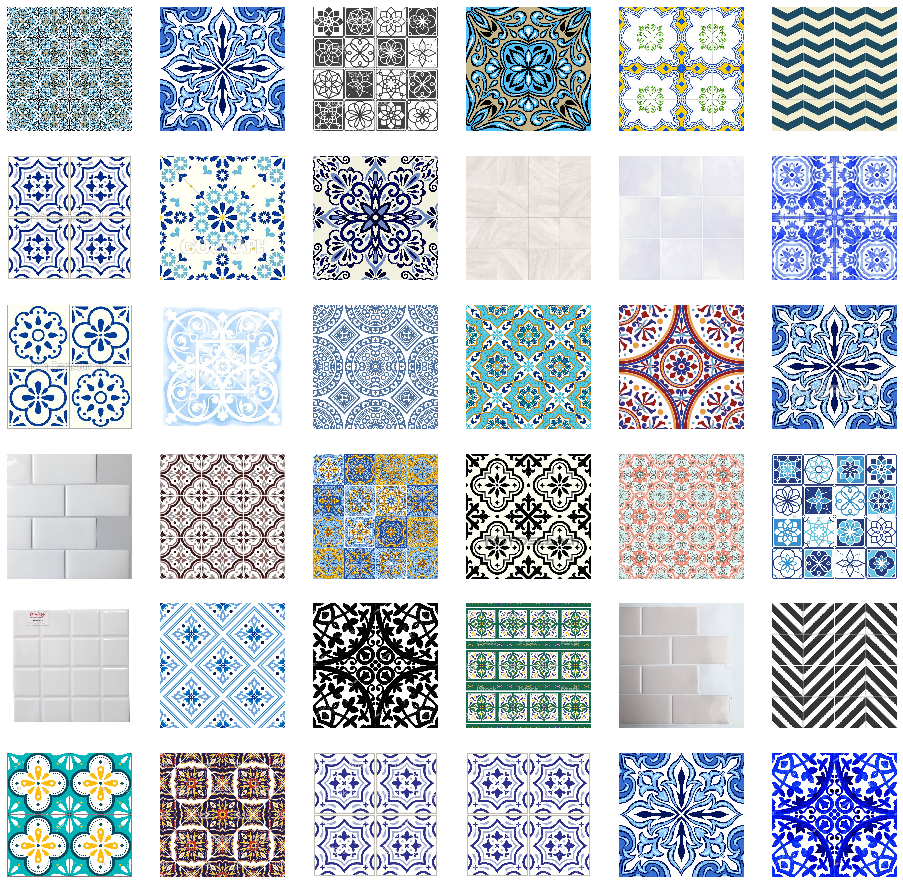

In [8]:
Tile.plot_grid(
    [Tile(cv2.imread('dataset/{}/{}'.format(folder, img_file))[...,::-1]) for img_file in sample_multitile[:36]],
    cols=6
)

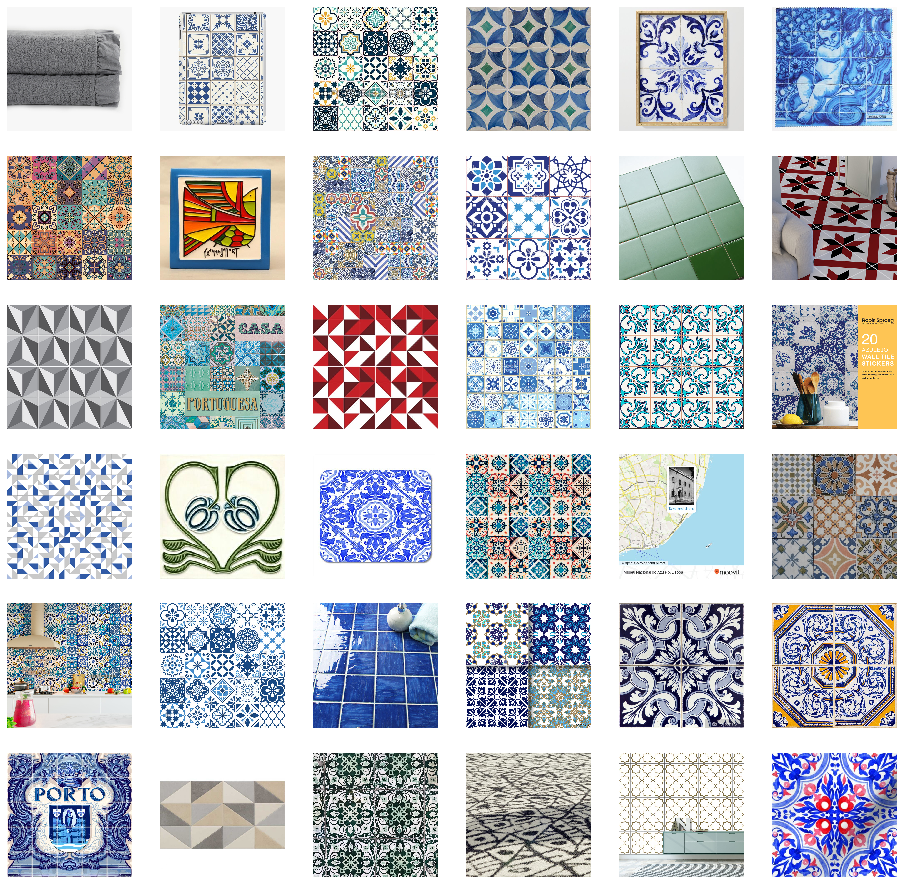

In [9]:
sample_other = [img_file for img_file in sample_square if img_file not in sample_symmetric + sample_multitile]
Tile.plot_grid(
    [Tile(cv2.imread('dataset/{}/{}'.format(folder, img_file))[...,::-1]) for img_file in sample_other[:36]],
    cols=6
)

In [10]:
with open('symmetric_{}.txt'.format(folder), 'w') as filehandle:
    for filename in sample_symmetric:
        filehandle.write('%s\n' % filename)

In [11]:
with open('multitile_{}.txt'.format(folder), 'w') as filehandle:
    for filename in sample_multitile:
        filehandle.write('%s\n' % filename)

In [12]:
len(set(sample_symmetric).union (set(sample_multitile)))

110